### IMPORT LIBRARIES

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imshow
from skimage.transform import resize
from skimage.color import gray2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169

### IMPORT / VIEWING / PREPROCESSING DATASET

> `DATA AUGMENTATION`

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

In [6]:
train_dataset  = train_datagen.flow_from_directory(directory = '../Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 4098 images belonging to 4 classes.


In [7]:
valid_dataset = valid_datagen.flow_from_directory(directory = '../Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 1023 images belonging to 4 classes.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.09s/it]


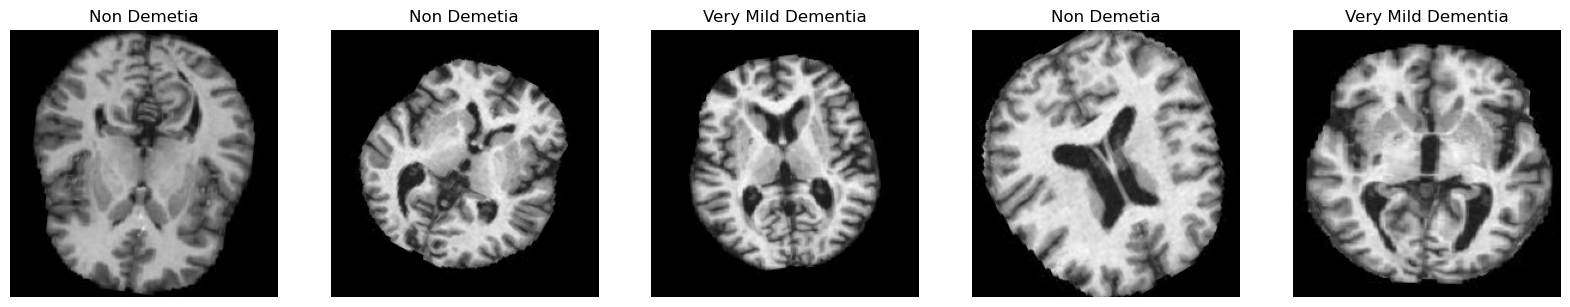

In [8]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

### MODEL BUILDING

In [13]:
# Model Initialization

base_model = DenseNet169(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")

In [14]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [15]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [9]:
# Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 dropout (Dropout)           (None, 7, 7, 1664)        0         
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 batch_normalization (BatchN  (None, 81536)            326144    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              166987776 
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                        

In [10]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

C:\Users\hp\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [60]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 500,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/500
33/33 [==============================] - ETA: 0s - loss: 0.7322 - auc: 0.9068 
Epoch 1: val_auc did not improve from 0.81969
33/33 [==============================] - 571s 17s/step - loss: 0.7322 - auc: 0.9068 - val_loss: 1.2542 - val_auc: 0.8042
Epoch 2/500
33/33 [==============================] - ETA: 0s - loss: 0.7167 - auc: 0.9080 
Epoch 2: val_auc improved from 0.81969 to 0.83385, saving model to .\best_weights.hdf5
33/33 [==============================] - 569s 17s/step - loss: 0.7167 - auc: 0.9080 - val_loss: 1.0465 - val_auc: 0.8338
Epoch 3/500
33/33 [==============================] - ETA: 0s - loss: 0.7008 - auc: 0.9115 
Epoch 3: val_auc did not improve from 0.83385
33/33 [==============================] - 559s 17s/step - loss: 0.7008 - auc: 0.9115 - val_loss: 1.1596 - val_auc: 0.8159
Epoch 4/500
33/33 [==============================] - ETA: 0s - loss: 0.6566 - auc: 0.9210 
Epoch 4: val_auc did not improve from 0.83385
33/33 [==============================] - 565s 17

Epoch 32/500
33/33 [==============================] - ETA: 0s - loss: 0.4807 - auc: 0.9578 
Epoch 32: val_auc improved from 0.86306 to 0.86374, saving model to .\best_weights.hdf5
33/33 [==============================] - 563s 17s/step - loss: 0.4807 - auc: 0.9578 - val_loss: 1.1469 - val_auc: 0.8637
Epoch 33/500
33/33 [==============================] - ETA: 0s - loss: 0.4888 - auc: 0.9562 
Epoch 33: val_auc did not improve from 0.86374
33/33 [==============================] - 628s 19s/step - loss: 0.4888 - auc: 0.9562 - val_loss: 1.2462 - val_auc: 0.8476
Epoch 34/500
33/33 [==============================] - ETA: 0s - loss: 0.4689 - auc: 0.9594 
Epoch 34: val_auc improved from 0.86374 to 0.86568, saving model to .\best_weights.hdf5
33/33 [==============================] - 635s 19s/step - loss: 0.4689 - auc: 0.9594 - val_loss: 1.0760 - val_auc: 0.8657
Epoch 35/500
33/33 [==============================] - ETA: 0s - loss: 0.4625 - auc: 0.9603 
Epoch 35: val_auc did not improve from 0.86568

33/33 [==============================] - 535s 16s/step - loss: 0.3922 - auc: 0.9709 - val_loss: 0.9835 - val_auc: 0.8886
Epoch 63/500
33/33 [==============================] - ETA: 0s - loss: 0.3812 - auc: 0.9729 
Epoch 63: val_auc did not improve from 0.88861
33/33 [==============================] - 530s 16s/step - loss: 0.3812 - auc: 0.9729 - val_loss: 1.0800 - val_auc: 0.8870
Epoch 64/500
33/33 [==============================] - ETA: 0s - loss: 0.4101 - auc: 0.9690 
Epoch 64: val_auc improved from 0.88861 to 0.89205, saving model to .\best_weights.hdf5
33/33 [==============================] - 529s 16s/step - loss: 0.4101 - auc: 0.9690 - val_loss: 0.9230 - val_auc: 0.8920
Epoch 65/500
33/33 [==============================] - ETA: 0s - loss: 0.3871 - auc: 0.9720 
Epoch 65: val_auc did not improve from 0.89205
33/33 [==============================] - 535s 16s/step - loss: 0.3871 - auc: 0.9720 - val_loss: 0.9719 - val_auc: 0.8893
Epoch 66/500
33/33 [==============================] - ETA:

33/33 [==============================] - 541s 16s/step - loss: 0.3127 - auc: 0.9817 - val_loss: 0.8343 - val_auc: 0.9093
Epoch 94/500
33/33 [==============================] - ETA: 0s - loss: 0.3221 - auc: 0.9802 
Epoch 94: val_auc did not improve from 0.90934
33/33 [==============================] - 551s 17s/step - loss: 0.3221 - auc: 0.9802 - val_loss: 1.0598 - val_auc: 0.8850
Epoch 95/500
33/33 [==============================] - ETA: 0s - loss: 0.3050 - auc: 0.9824 
Epoch 95: val_auc did not improve from 0.90934
33/33 [==============================] - 542s 16s/step - loss: 0.3050 - auc: 0.9824 - val_loss: 1.0384 - val_auc: 0.8918
Epoch 96/500
33/33 [==============================] - ETA: 0s - loss: 0.3182 - auc: 0.9806 
Epoch 96: val_auc did not improve from 0.90934
33/33 [==============================] - 538s 16s/step - loss: 0.3182 - auc: 0.9806 - val_loss: 1.2546 - val_auc: 0.8680
Epoch 97/500
33/33 [==============================] - ETA: 0s - loss: 0.3205 - auc: 0.9805 
Epoch 9

### MODEL EVALUATION

In [3]:
# Summarize history for loss

from keras.models import load_model
model_history=load_model('./best_weights.hdf5')

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

TypeError: 'NoneType' object is not subscriptable

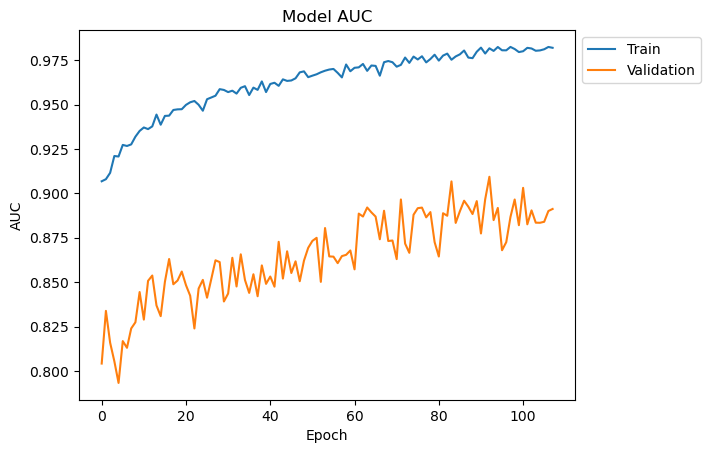

In [62]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()